# Primer Parcial
## Nombre : Tumiri Huanca Alex
### 1. Predecir el tipo de cambio del dólar para los meses de mayo a diciembre del 2021

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from tqdm import tqdm
import pandas as pd
import os

class Dataset_treatment(Dataset):
    def __init__(self, csv_file , root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        Mes = self.annotations.iloc[index, 0]
        PrecioDolar = self.annotations.iloc[index, 1]
        return (Mes, PrecioDolar)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Dataset_treatment(
    csv_file= "dolar.csv",
    root_dir= "DataSet",
    transform = transforms.ToTensor(),
    )     

print(len(dataset))
print(dataset.__getitem__(23))
print("++++++++++++++++++++++")

dataloader = DataLoader(dataset, batch_size=23 , shuffle=True)

x , y = next(iter(dataloader))
print(x)
print("--------------------------")
print(y.shape)


class SimpleRNN(torch.nn.Module):
    def __init__(self):
        super.__init__()
        #Instancion nuestra Red Neuronal Recurrente
        self.rnn = torch.nn.RNN(
        input_size = 1, #El Tamaño de la entrada
        hidden_size = 1, #La Cantidad de Neuronas en la Capa Oculta
        num_layers =  1, #La Cantidad de Capaz Ocultas que tendra
        batch_first = True #    
        )
        
    def Forward(self, x):
        y , _ = self.rnn(x)
        # Obtenemos la Ultima salida
        return y[: , -1]

rnn = SimpleRNN()


def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds
    
fit(rnn , dataloader)

24
('Feb 2021 ', 6.905)
++++++++++++++++++++++
('Mar 2021 ', 'Nov 2020 ', 'Sep 2020 ', 'Ago 2020 ', 'Sep 2019 ', 'Abr 2020 ', 'Ene 2021 ', 'Oct 2020 ', 'Abr 2021 ', 'May 2021 ', 'Jul 2019 ', 'Jul 2020 ', 'Ago 2019 ', 'Jun 2020 ', 'Dic 2019 ', 'Nov 2019 ', 'Oct 2019 ', 'Feb 2021 ', 'Jun 2019 ', 'May 2020 ', 'Ene 2020 ', 'Feb 2020 ', 'Dic 2020 ')
--------------------------
torch.Size([23])


TypeError: descriptor '__init__' of 'super' object needs an argument

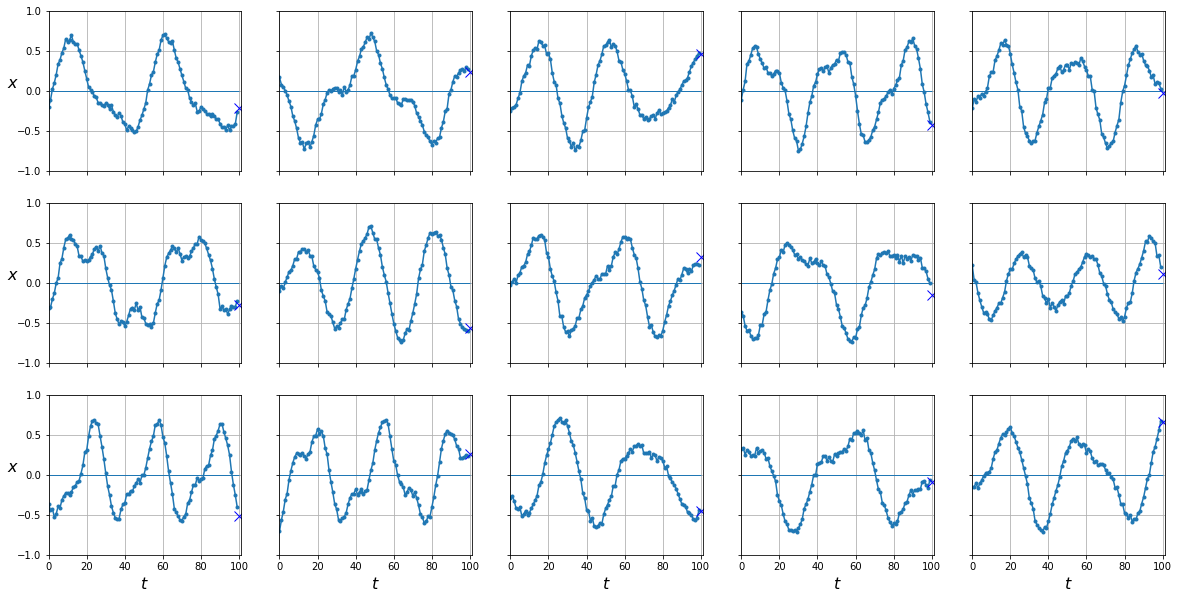

In [6]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 100
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)

